In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import datetime
import random
import torch.nn.utils as utils
import uuid

Get Data

In [2]:
def get_data(path):
    image_extensions = ['.jpg']
    image_names = []
    for filename in os.listdir(path):
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            image_names.append(filename)
    return image_names

In [3]:
path = '/Users/ayanfe/Documents/Datasets/animefaces256cleaner'
#path = '/Users/ayanfe/Documents/Datasets/Landscape'
model_path = '/Users/ayanfe/Documents/Code/Diffusion-Model/weights/waifu-diffusion-n-cts_1000-4000.pth'
#model_path = '/Users/ayanfe/Documents/Code/Diffusion-Model/weights/landscape-diffusion-n-cts_1000-4000.pth'
image_names = get_data(path)
print("Image Length: ",len(image_names))

Image Length:  92219


In [4]:
timesteps = 100


# create a fixed beta schedule
def linear():
    beta = np.linspace(0.0001, 0.02, timesteps)
    alpha = 1 - beta
    alpha_bar = np.cumprod(alpha, 0)
    alpha_bar = np.concatenate((np.array([1.]), alpha_bar[:-1]), axis=0)
    sqrt_alpha_bar = np.sqrt(alpha_bar)
    one_minus_sqrt_alpha_bar = np.sqrt(1-alpha_bar)
    return sqrt_alpha_bar, one_minus_sqrt_alpha_bar

def cosine(t, timesteps=1000):
    min_signal_rate = 0.02
    max_signal_rate = 0.95

    # Ensure t is a float tensor
    t = t.float()
    
    # Normalize t by the number of timesteps
    t = t / timesteps

    # Compute start and end angles using arccos, ensuring the computation stays within PyTorch
    start_angle = torch.arccos(torch.tensor([max_signal_rate], device=t.device))
    end_angle = torch.arccos(torch.tensor([min_signal_rate], device=t.device))
    
    # Calculate diffusion angles
    diffusion_angles = start_angle + t * (end_angle - start_angle)
    
    # Calculate signal and noise rates using PyTorch operations
    signal_rates = torch.cos(diffusion_angles)
    noise_rates = torch.sin(diffusion_angles)

    return noise_rates, signal_rates
    
# this function will help us set the RNG key for Numpy
def set_key(key):
    np.random.seed(key)

# this function will add noise to the input as per the given timestamp
def forward_linear_noise(key, x_0, t):
    set_key(key)
    noise = np.random.normal(size=x_0.shape)
    sqrt_alpha_bar, one_minus_sqrt_alpha_bar = linear()
    reshaped_sqrt_alpha_bar_t = np.reshape(np.take(sqrt_alpha_bar, t), (-1, 1, 1, 1))
    reshaped_one_minus_sqrt_alpha_bar_t = np.reshape(np.take(one_minus_sqrt_alpha_bar, t), (-1, 1, 1, 1))
    noisy_image = reshaped_sqrt_alpha_bar_t  * ((x_0 - 127.5)/127.5) + reshaped_one_minus_sqrt_alpha_bar_t  * noise
    return noisy_image, noise

def forward_cosine_noise(key, x_0, t):
    set_key(key)
    noise = np.random.normal(size=x_0.shape)
    noise_rates,signal_rates = cosine(t)
    reshaped_noise_rates = np.reshape(noise_rates, (-1, 1, 1, 1))
    reshaped_signal_rates = np.reshape(signal_rates, (-1, 1, 1, 1))
    noisy_image = reshaped_signal_rates  * ((x_0 - 127.5)/127.5) + reshaped_noise_rates * noise
    return noisy_image, noise

# this function will be used to create sample timestamps between 0 & T
def generate_timestamp(key, num):
    set_key(key)
    return torch.randint(0, timesteps,(num,), dtype=torch.int32)

def reshape_img(img,size = (64,64)):
    data = cv2.resize(img,size)
    data = np.transpose(data,(2,0,1))
    return data

def save_img(img,path):
    plt.imshow(np.transpose(img[-1].cpu().numpy(), (1, 2, 0)))
    plt.axis('off')  # If you want to hide the axes
    # Generate a random filename
    random_filename = str(uuid.uuid4()) + '.png'

    # Specify the directory where you want to save the image
    save_directory = path

    # Create the full path including the directory and filename
    full_path = os.path.join(save_directory, random_filename)
    # Save the image with the random filename
    plt.savefig(full_path, bbox_inches='tight', pad_inches=0)

Visualize the output image at some timesteps

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


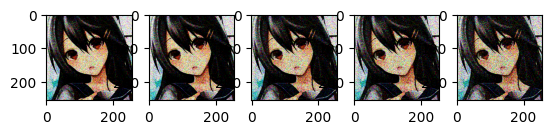

In [5]:
# Let us visualize the output image at a few timestamps
sample_data = plt.imread(path+'/'+image_names[0])

for index, i in enumerate([0,10, 50, 60, 99]):
    noisy_im, noise = forward_cosine_noise(0, np.expand_dims(sample_data, 0), torch.from_numpy(np.array([i,])))
    plt.subplot(1, 5, index+1)
    plt.imshow(np.squeeze(noisy_im,0))
    
plt.show()

In [6]:
def ddim(x_t, pred_noise, t ,noise_rate, signal_rate, sigma_t):
    alpha_t_bar = signal_rate  # Cast t to integer before using np.take
    alpha_t_minus_one = noise_rate  # Similarly, cast t-1 to integer

    pred = (x_t - ((1 - alpha_t_bar) ** 0.5) * pred_noise)/ (alpha_t_bar ** 0.5)
    pred = (alpha_t_minus_one ** 0.5) * pred

    pred = pred + ((1 - alpha_t_minus_one - (sigma_t ** 2)) ** 0.5) * pred_noise
    eps_t = np.random.normal(size=x_t.shape)
    pred = pred+(sigma_t * eps_t)

    return pred

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
def inference(model, device, num_samples=5):
    # Define number of inference loops to run
    inference_timesteps = 30
    
    # Create a range of inference steps that the output should be sampled at
    inference_range = torch.flip(torch.linspace(0, timesteps-1, steps=inference_timesteps), dims=[0])
    
    x = torch.randn(1, 3, 64, 64).to(device)  # Initialize a random input image on GPU
    img_list = []
    img_list.append(np.squeeze(x.cpu().numpy(), 0))  # Append the initial image

    # Iterate over inference_timesteps
    for i in range(inference_timesteps):
        t = np.expand_dims(inference_range[i], 0)
        t = torch.from_numpy(t).type(torch.float32).to(device)
        t = torch.reshape(t, (-1, 1)).type(torch.float32)
        
        pred_noise = model(x, t/timesteps).detach().to(device)  # Obtain predicted noise
        noise_rates, signal_rates = cosine(t,timesteps = timesteps)
        x = ddim(x.cpu().detach().numpy(), pred_noise.cpu().detach().numpy(),t.cpu().detach().numpy(),
                 noise_rates.cpu().detach().numpy() ,signal_rates.cpu().detach().numpy() ,0)  # Perform denoising using DDIM
        x = torch.from_numpy(x).type(torch.float32).to(device)  # Transfer denoised image back to GPU
        img_list.append(np.squeeze(x.cpu().detach().numpy(), 0))  # Append the denoised image
    
    # Visualize the final denoised image
    plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
    plt.show()

In [9]:
def reverse_diffusion(model, diffusion_steps, device='mps'):
    step_size = 1.0 / diffusion_steps
    current_images = torch.randn(1, 3, 64, 64).to(device)
    model.eval()
    with torch.no_grad():
        for step in range(diffusion_steps):
            diffusion_times = torch.ones((1, 1)).to(device) - step * step_size 
            diffusion_times.to(device)

            # Ensure model and other  operations are also moved to the device
            pred_noises = model(current_images, diffusion_times)
            save_img(pred_noises,'Noise/')
            noise_rates, signal_rates = cosine((diffusion_times.to("cpu") * timesteps),timesteps=timesteps)
            
            pred_noises = pred_noises.to(device)  # Move to the specified device
            noise_rates = noise_rates.to(device)  # Move to the specified device
            signal_rates = signal_rates.to(device)  # Move to the specified device
            
            pred_images = (current_images - noise_rates * pred_noises) / signal_rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = cosine((next_diffusion_times.to("cpu")*timesteps),timesteps=timesteps)
            
            next_noise_rates = next_noise_rates.to(device)  # Move to the specified device
            next_signal_rates = next_signal_rates.to(device)  # Move to the specified device

            #save_img(pred_images,'Inference Steps/')
            
            current_images = (next_signal_rates * pred_images + next_noise_rates * pred_noises)
    model.train()
    pred_images = (pred_images.clamp(-1, 1) + 1) / 2
    
    # Detach the tensor before converting it to a NumPy array
    plt.imshow(np.transpose(pred_images[-1].cpu().numpy(), (1, 2, 0)))
    plt.show()


In [10]:
start = 1
img_length = len(image_names)
data_length = 5200
data_idx = list(range(0,data_length+32))
random.shuffle(data_idx)

def training_loop(n_epochs, optimizer, model, loss_fn, device, accumulation_steps=1, 
                  epoch_start = 0, batch_size = 64, max_grad_norm=1.0, repeats = 5, timesteps = 200):
    global start
    with torch.autograd.set_detect_anomaly(True):
        for epoch in range(epoch_start, n_epochs + 1):
            loss_train = 0.0
            accumulated_loss = 0.0
            loss_mae = 0.0
            random.shuffle(data_idx)
            # Use tqdm function for the progress bar
            with tqdm(range(start, (repeats*data_length)//batch_size), desc=f'Epoch {epoch}', unit=' steps') as pbar:
                st = 0
                for x in pbar:
                    # Training loop code
                    sp = st + batch_size
                    if sp > data_length:
                        st = 0
                        sp = st + batch_size
                    img_arr = []
                    for i in range(st,sp):
                        img = plt.imread(path + '/' + image_names[data_idx[i]])
                        img = reshape_img(img)
                        img = np.expand_dims(img, 0)
                        img_arr.append(img)
                    st+= batch_size
                    
                    t = generate_timestamp(None, batch_size)
                    t = torch.reshape(t, (-1, 1)).type(torch.float32)
                    
                    imgs, noise = forward_cosine_noise(None, np.squeeze(np.array(img_arr)), t)
                    if torch.is_tensor(imgs):
                        imgs = imgs.type(torch.float32).to(device)
                    else:
                        imgs = torch.from_numpy(imgs).type(torch.float32).to(device)
                    noise = torch.from_numpy(noise).type(torch.float32).to(device)
                    t = t.to(device)
                    t /= timesteps
                    outputs = model(imgs, t)
                    
                    loss = loss_fn(outputs, noise)
                    
                    # Perform gradient accumulation
                    accumulated_loss += loss / accumulation_steps
                    
                    if x % accumulation_steps == 0:
                        accumulated_loss.backward()

                        # Clip gradients
                        utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                        
                        optimizer.step()
                        optimizer.zero_grad()
                        accumulated_loss = 0.0  # Reset accumulated loss
                    
                    loss_train += loss.item()
                    outputs.detach_()
                    pbar.set_postfix(loss=loss.item())
                
            avg_loss_epoch = loss_train / ((repeats*data_length)//batch_size)
            with open("waifu-diffusion-n-cts_1000-4000-loss.txt", "a") as file:
                file.write(f"{avg_loss_epoch}\n")
            
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / ((repeats*data_length)//batch_size)))
            #torch.save(model.state_dict(), path1)
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, model_path)
            #inference(model, device)
            if epoch % 5 == 0:
                #inference(model, device)
                reverse_diffusion(model,50)
            if epoch % 20 == 0 and timesteps <= 1000:
                timesteps += 100
            
                

In [11]:
from unet import Unet

model = Unet()
#model.load_state_dict(torch.load(model_two))
device = torch.device("mps")
model.to(device)
optimizer = optim.AdamW(model.parameters(),lr=5e-5,weight_decay=1e-4)  #  <3>
#checkpoint = torch.load(model_path)
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#print(epoch)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for im

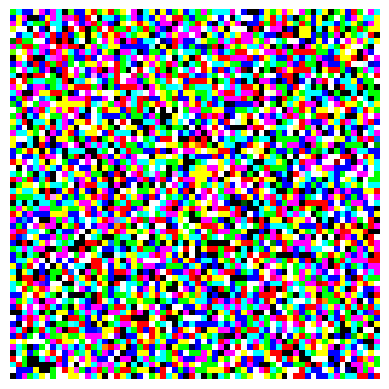

In [12]:
reverse_diffusion(model,50)

Total parameters:  22287014


Epoch 1: 100%|████████████████| 405/405 [05:43<00:00,  1.18 steps/s, loss=0.684]


2024-04-12 17:59:16.762241 Epoch 1, Training loss 0.8180286750711244


Epoch 2: 100%|████████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.585]


2024-04-12 18:04:56.676957 Epoch 2, Training loss 0.6235317426362061


Epoch 3: 100%|█████████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.51]


2024-04-12 18:10:36.525311 Epoch 3, Training loss 0.5463611467424871


Epoch 4: 100%|█████████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.47]


2024-04-12 18:16:16.583342 Epoch 4, Training loss 0.4956567952491967


Epoch 5: 100%|████████████████| 405/405 [05:40<00:00,  1.19 steps/s, loss=0.431]


2024-04-12 18:21:57.305718 Epoch 5, Training loss 0.4552443133199156


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

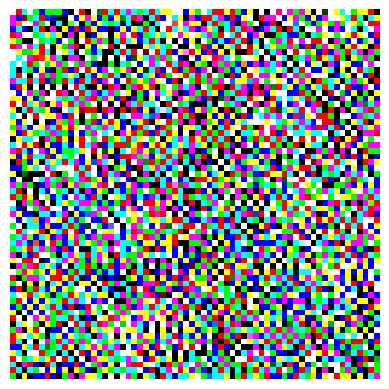

Epoch 6: 100%|████████████████| 405/405 [05:40<00:00,  1.19 steps/s, loss=0.415]


2024-04-12 18:27:47.176055 Epoch 6, Training loss 0.4216445290249557


Epoch 7: 100%|████████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.381]


2024-04-12 18:33:26.703828 Epoch 7, Training loss 0.39442176081864116


Epoch 8: 100%|████████████████| 405/405 [05:42<00:00,  1.18 steps/s, loss=0.363]


2024-04-12 18:39:09.525928 Epoch 8, Training loss 0.3703737253038754


Epoch 9: 100%|█████████████████| 405/405 [05:40<00:00,  1.19 steps/s, loss=0.33]


2024-04-12 18:44:50.246255 Epoch 9, Training loss 0.3501519451440849


Epoch 10: 100%|███████████████| 405/405 [05:37<00:00,  1.20 steps/s, loss=0.332]


2024-04-12 18:50:28.242060 Epoch 10, Training loss 0.3320645424239154


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

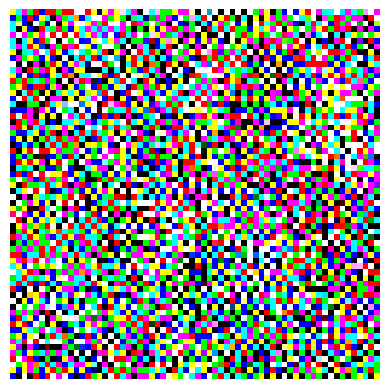

Epoch 11: 100%|███████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.301]


2024-04-12 18:56:17.200382 Epoch 11, Training loss 0.3165087066407274


Epoch 12: 100%|███████████████| 405/405 [05:41<00:00,  1.18 steps/s, loss=0.297]


2024-04-12 19:01:59.466974 Epoch 12, Training loss 0.30386591221898646


Epoch 13: 100%|███████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.293]


2024-04-12 19:07:39.267576 Epoch 13, Training loss 0.29259877303257364


Epoch 14: 100%|███████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.274]


2024-04-12 19:13:19.054490 Epoch 14, Training loss 0.2807246366598336


Epoch 15: 100%|███████████████| 405/405 [05:40<00:00,  1.19 steps/s, loss=0.252]


2024-04-12 19:18:59.607461 Epoch 15, Training loss 0.27006070323178333


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

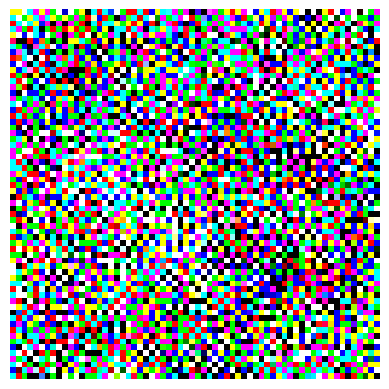

Epoch 16: 100%|███████████████| 405/405 [05:41<00:00,  1.19 steps/s, loss=0.265]


2024-04-12 19:24:50.815414 Epoch 16, Training loss 0.26064576021409386


Epoch 17: 100%|███████████████| 405/405 [05:41<00:00,  1.19 steps/s, loss=0.252]


2024-04-12 19:30:32.713033 Epoch 17, Training loss 0.25202613349618586


Epoch 18: 100%|███████████████| 405/405 [05:40<00:00,  1.19 steps/s, loss=0.233]


2024-04-12 19:36:13.651593 Epoch 18, Training loss 0.2432888128560752


Epoch 19: 100%|████████████████| 405/405 [05:41<00:00,  1.19 steps/s, loss=0.22]


2024-04-12 19:41:55.608243 Epoch 19, Training loss 0.2362283566241781


Epoch 20: 100%|███████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.229]


2024-04-12 19:47:35.917570 Epoch 20, Training loss 0.22851887594890125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

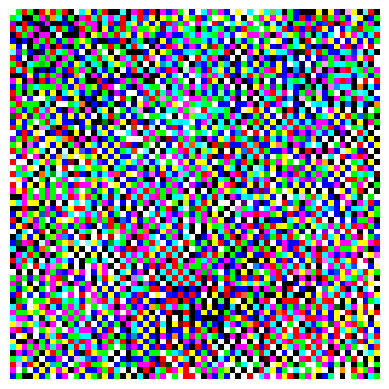

Epoch 21: 100%|███████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.226]


2024-04-12 19:53:25.381077 Epoch 21, Training loss 0.22276599077608786


Epoch 22: 100%|███████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.215]


2024-04-12 19:59:04.912861 Epoch 22, Training loss 0.21737506681034718


Epoch 23: 100%|███████████████| 405/405 [05:36<00:00,  1.20 steps/s, loss=0.207]


2024-04-12 20:04:41.925581 Epoch 23, Training loss 0.21142085336992894


Epoch 24: 100%|███████████████| 405/405 [05:50<00:00,  1.15 steps/s, loss=0.207]


2024-04-12 20:10:33.041821 Epoch 24, Training loss 0.20663770739668108


Epoch 25: 100%|███████████████| 405/405 [05:51<00:00,  1.15 steps/s, loss=0.201]


2024-04-12 20:16:24.932606 Epoch 25, Training loss 0.202550114962855


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

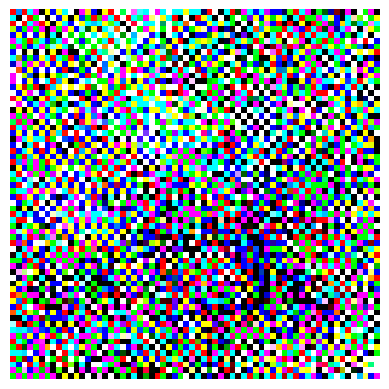

Epoch 26: 100%|███████████████| 405/405 [05:41<00:00,  1.19 steps/s, loss=0.192]


2024-04-12 20:22:15.704675 Epoch 26, Training loss 0.197853558976662


Epoch 27: 100%|███████████████| 405/405 [05:36<00:00,  1.20 steps/s, loss=0.185]


2024-04-12 20:27:52.832988 Epoch 27, Training loss 0.19308171769961935


Epoch 28: 100%|███████████████| 405/405 [05:38<00:00,  1.20 steps/s, loss=0.186]


2024-04-12 20:33:31.301518 Epoch 28, Training loss 0.18926306487304237


Epoch 29: 100%|███████████████| 405/405 [05:37<00:00,  1.20 steps/s, loss=0.169]


2024-04-12 20:39:09.108229 Epoch 29, Training loss 0.18679992219644226


Epoch 30: 100%|███████████████| 405/405 [05:38<00:00,  1.20 steps/s, loss=0.184]


2024-04-12 20:44:48.011209 Epoch 30, Training loss 0.18421549364704218


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

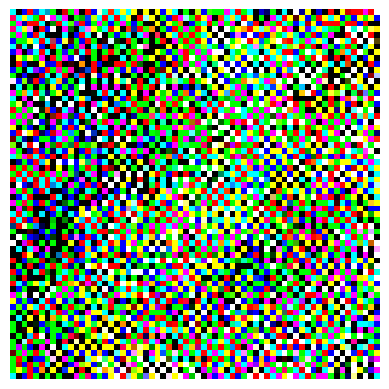

Epoch 31: 100%|███████████████| 405/405 [05:41<00:00,  1.19 steps/s, loss=0.182]


2024-04-12 20:50:39.163736 Epoch 31, Training loss 0.1819126628375993


Epoch 32: 100%|████████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.18]


2024-04-12 20:56:18.904542 Epoch 32, Training loss 0.17834805572414633


Epoch 33: 100%|███████████████| 405/405 [05:38<00:00,  1.20 steps/s, loss=0.196]


2024-04-12 21:01:58.004460 Epoch 33, Training loss 0.17702032064128978


Epoch 34: 100%|███████████████| 405/405 [05:43<00:00,  1.18 steps/s, loss=0.176]


2024-04-12 21:07:42.266499 Epoch 34, Training loss 0.1754551007976673


Epoch 35: 100%|███████████████| 405/405 [05:41<00:00,  1.19 steps/s, loss=0.178]


2024-04-12 21:13:24.034264 Epoch 35, Training loss 0.1717209190570662


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

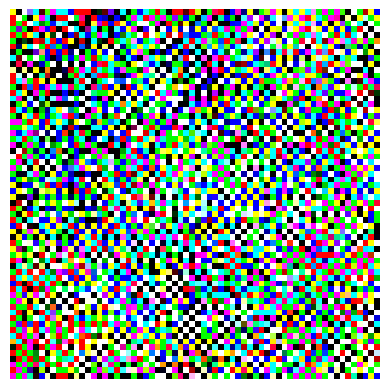

Epoch 36: 100%|████████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.16]


2024-04-12 21:19:12.791722 Epoch 36, Training loss 0.16935677261188112


Epoch 37: 100%|███████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.167]


2024-04-12 21:24:52.908586 Epoch 37, Training loss 0.16832919613334346


Epoch 38: 100%|███████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.165]


2024-04-12 21:30:33.310224 Epoch 38, Training loss 0.16681947625182533


Epoch 39: 100%|███████████████| 405/405 [05:37<00:00,  1.20 steps/s, loss=0.168]


2024-04-12 21:36:11.564060 Epoch 39, Training loss 0.16437999338939271


Epoch 40: 100%|███████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.164]


2024-04-12 21:41:51.045886 Epoch 40, Training loss 0.16237495182623418


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

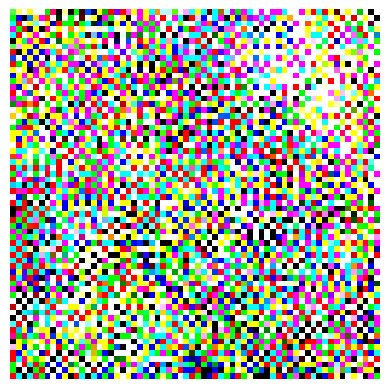

Epoch 41: 100%|███████████████| 405/405 [05:37<00:00,  1.20 steps/s, loss=0.155]


2024-04-12 21:47:37.857061 Epoch 41, Training loss 0.16129319531283356


Epoch 42: 100%|███████████████| 405/405 [05:38<00:00,  1.20 steps/s, loss=0.148]


2024-04-12 21:53:16.716503 Epoch 42, Training loss 0.16039820044792344


Epoch 43: 100%|███████████████| 405/405 [05:38<00:00,  1.20 steps/s, loss=0.161]


2024-04-12 21:58:56.048704 Epoch 43, Training loss 0.15892820383233977


Epoch 44: 100%|████████████████| 405/405 [05:36<00:00,  1.20 steps/s, loss=0.16]


2024-04-12 22:04:33.132006 Epoch 44, Training loss 0.15767234383985915


Epoch 45: 100%|███████████████| 405/405 [05:36<00:00,  1.20 steps/s, loss=0.158]


2024-04-12 22:10:10.273400 Epoch 45, Training loss 0.15567366826563633


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

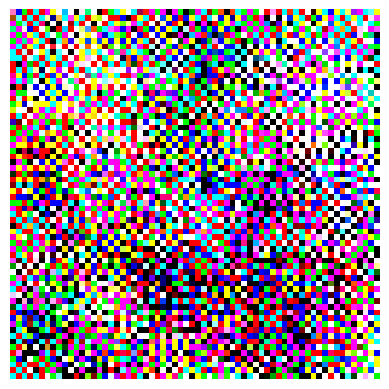

Epoch 46: 100%|███████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.159]


2024-04-12 22:15:59.506509 Epoch 46, Training loss 0.15537144753880103


Epoch 47: 100%|███████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.142]


2024-04-12 22:21:39.753462 Epoch 47, Training loss 0.1536661075253792


Epoch 48: 100%|████████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.15]


2024-04-12 22:27:19.453851 Epoch 48, Training loss 0.1536004596522876


Epoch 49: 100%|███████████████| 405/405 [05:40<00:00,  1.19 steps/s, loss=0.153]


2024-04-12 22:33:00.137773 Epoch 49, Training loss 0.15123942923810094


Epoch 50: 100%|███████████████| 405/405 [05:40<00:00,  1.19 steps/s, loss=0.142]


2024-04-12 22:38:40.889531 Epoch 50, Training loss 0.15035548707094099


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

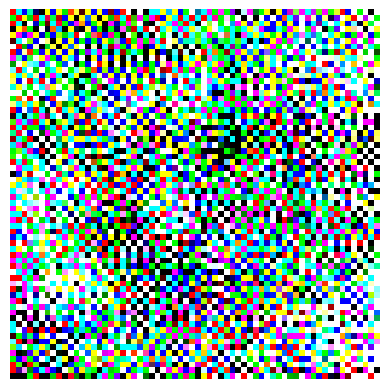

Epoch 51: 100%|████████████████| 405/405 [05:38<00:00,  1.20 steps/s, loss=0.15]


2024-04-12 22:44:29.231008 Epoch 51, Training loss 0.14914152870330905


Epoch 52: 100%|███████████████| 405/405 [05:38<00:00,  1.20 steps/s, loss=0.148]


2024-04-12 22:50:08.397137 Epoch 52, Training loss 0.14907600136079224


Epoch 53: 100%|███████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.141]


2024-04-12 22:55:48.041497 Epoch 53, Training loss 0.1483460473529811


Epoch 54: 100%|███████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.134]


2024-04-12 23:01:27.869870 Epoch 54, Training loss 0.14737295289638594


Epoch 55: 100%|███████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.143]


2024-04-12 23:07:07.923141 Epoch 55, Training loss 0.14691025462790663


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

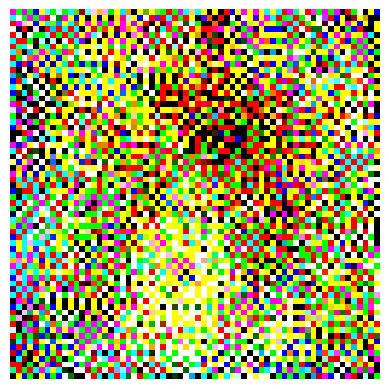

Epoch 56: 100%|███████████████| 405/405 [05:37<00:00,  1.20 steps/s, loss=0.147]


2024-04-12 23:12:55.116927 Epoch 56, Training loss 0.14584590311120885


Epoch 57: 100%|███████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.143]


2024-04-12 23:18:35.289534 Epoch 57, Training loss 0.14500206206085647


Epoch 58: 100%|███████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.132]


2024-04-12 23:24:15.186514 Epoch 58, Training loss 0.14373265713306482


Epoch 59: 100%|███████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.133]


2024-04-12 23:29:54.917594 Epoch 59, Training loss 0.1434450890556932


Epoch 60: 100%|████████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.14]


2024-04-12 23:35:35.262325 Epoch 60, Training loss 0.1431911693784991


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

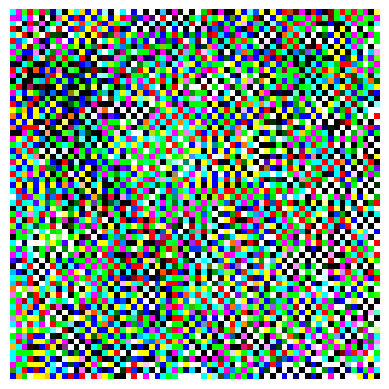

Epoch 61: 100%|███████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.142]


2024-04-12 23:41:24.706015 Epoch 61, Training loss 0.14221654678213186


Epoch 62: 100%|███████████████| 405/405 [05:38<00:00,  1.20 steps/s, loss=0.145]


2024-04-12 23:47:03.268821 Epoch 62, Training loss 0.14122278300191968


Epoch 63: 100%|███████████████| 405/405 [05:37<00:00,  1.20 steps/s, loss=0.155]


2024-04-12 23:52:41.697051 Epoch 63, Training loss 0.14228416036062053


Epoch 64: 100%|███████████████| 405/405 [05:38<00:00,  1.20 steps/s, loss=0.138]


2024-04-12 23:58:20.687498 Epoch 64, Training loss 0.14087184593815522


Epoch 65: 100%|███████████████| 405/405 [05:38<00:00,  1.20 steps/s, loss=0.147]


2024-04-13 00:03:59.411078 Epoch 65, Training loss 0.1400513737439522


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

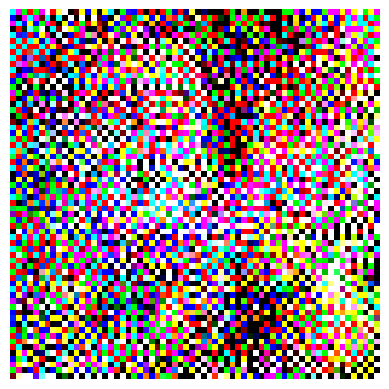

Epoch 66: 100%|███████████████| 405/405 [05:37<00:00,  1.20 steps/s, loss=0.145]


2024-04-13 00:09:46.950735 Epoch 66, Training loss 0.1405805845565984


Epoch 67: 100%|███████████████| 405/405 [05:38<00:00,  1.20 steps/s, loss=0.129]


2024-04-13 00:15:25.418082 Epoch 67, Training loss 0.13921585066124723


Epoch 68: 100%|████████████████| 405/405 [05:38<00:00,  1.20 steps/s, loss=0.14]


2024-04-13 00:21:04.045071 Epoch 68, Training loss 0.13810068086303515


Epoch 69: 100%|████████████████| 405/405 [05:38<00:00,  1.20 steps/s, loss=0.14]


2024-04-13 00:26:42.849410 Epoch 69, Training loss 0.1380735364343439


Epoch 70: 100%|███████████████| 405/405 [05:40<00:00,  1.19 steps/s, loss=0.147]


2024-04-13 00:32:23.732312 Epoch 70, Training loss 0.13840421801203578


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

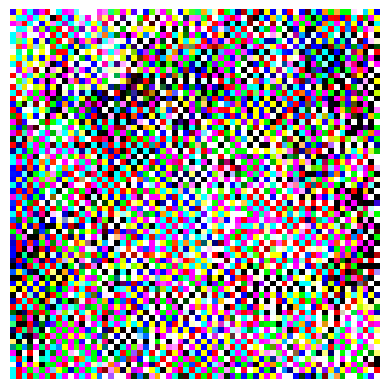

Epoch 71: 100%|███████████████| 405/405 [05:37<00:00,  1.20 steps/s, loss=0.139]


2024-04-13 00:38:10.431284 Epoch 71, Training loss 0.1379324888324209


Epoch 72: 100%|████████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.16]


2024-04-13 00:43:50.074843 Epoch 72, Training loss 0.13788909400845395


Epoch 73: 100%|███████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.138]


2024-04-13 00:49:30.044120 Epoch 73, Training loss 0.13830876124683272


Epoch 74: 100%|███████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.147]


2024-04-13 00:55:10.332467 Epoch 74, Training loss 0.1368028812220531


Epoch 75: 100%|███████████████| 405/405 [05:40<00:00,  1.19 steps/s, loss=0.137]


2024-04-13 01:00:50.866532 Epoch 75, Training loss 0.13683968571386315


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

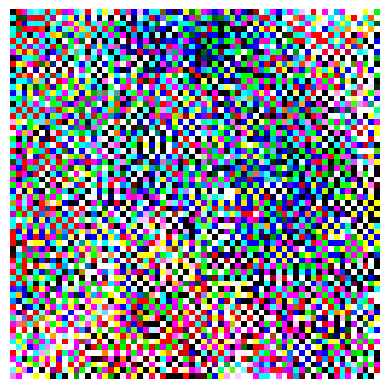

Epoch 76: 100%|███████████████| 405/405 [05:40<00:00,  1.19 steps/s, loss=0.143]


2024-04-13 01:06:41.051048 Epoch 76, Training loss 0.13588938564796166


Epoch 77: 100%|███████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.137]


2024-04-13 01:12:20.702979 Epoch 77, Training loss 0.13501271113679914


Epoch 78: 100%|███████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.133]


2024-04-13 01:18:00.383113 Epoch 78, Training loss 0.1363905547324366


Epoch 79: 100%|███████████████| 405/405 [05:40<00:00,  1.19 steps/s, loss=0.134]


2024-04-13 01:23:41.153887 Epoch 79, Training loss 0.13602178538300722


Epoch 80: 100%|███████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.131]


2024-04-13 01:29:21.606649 Epoch 80, Training loss 0.13515093696895492


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

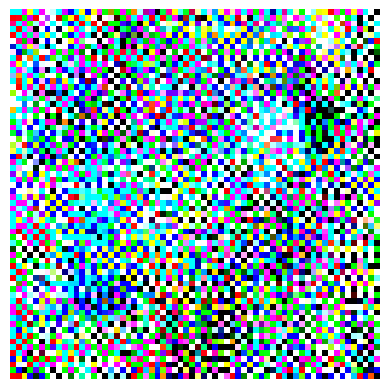

Epoch 81: 100%|███████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.145]


2024-04-13 01:35:11.297271 Epoch 81, Training loss 0.1342494675311549


Epoch 82: 100%|███████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.136]


2024-04-13 01:40:51.490303 Epoch 82, Training loss 0.1338202921591075


Epoch 83: 100%|███████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.143]


2024-04-13 01:46:31.651294 Epoch 83, Training loss 0.1331548603260752


Epoch 84: 100%|███████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.139]


2024-04-13 01:52:11.484103 Epoch 84, Training loss 0.13338058623554083


Epoch 85: 100%|███████████████| 405/405 [05:37<00:00,  1.20 steps/s, loss=0.145]


2024-04-13 01:57:49.221189 Epoch 85, Training loss 0.1328394223426657


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

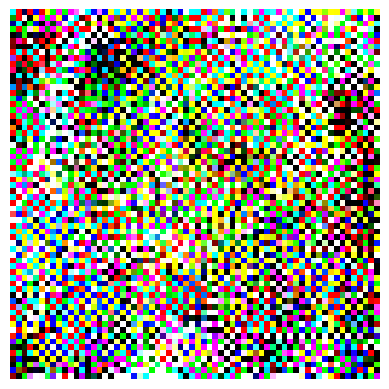

Epoch 86: 100%|███████████████| 405/405 [05:38<00:00,  1.20 steps/s, loss=0.126]


2024-04-13 02:03:37.468020 Epoch 86, Training loss 0.1322194322796878


Epoch 87: 100%|████████████████| 405/405 [05:38<00:00,  1.20 steps/s, loss=0.13]


2024-04-13 02:09:16.240202 Epoch 87, Training loss 0.13223889317785578


Epoch 88: 100%|███████████████| 405/405 [05:37<00:00,  1.20 steps/s, loss=0.143]


2024-04-13 02:14:54.692512 Epoch 88, Training loss 0.13167029033814157


Epoch 89: 100%|███████████████| 405/405 [05:37<00:00,  1.20 steps/s, loss=0.135]


2024-04-13 02:20:32.861733 Epoch 89, Training loss 0.1315725153780042


Epoch 90: 100%|███████████████| 405/405 [05:37<00:00,  1.20 steps/s, loss=0.141]


2024-04-13 02:26:11.202634 Epoch 90, Training loss 0.13122847999257994


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

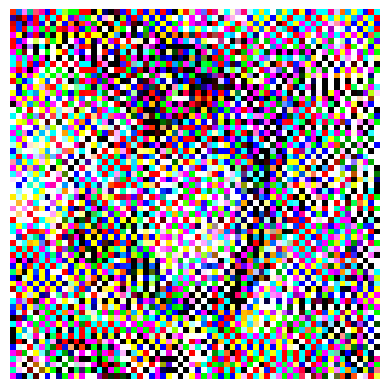

Epoch 91: 100%|███████████████| 405/405 [05:37<00:00,  1.20 steps/s, loss=0.129]


2024-04-13 02:31:58.919104 Epoch 91, Training loss 0.1307147952356362


Epoch 92: 100%|████████████████| 405/405 [05:37<00:00,  1.20 steps/s, loss=0.13]


2024-04-13 02:37:36.854125 Epoch 92, Training loss 0.1308474063763184


Epoch 93: 100%|███████████████| 405/405 [05:37<00:00,  1.20 steps/s, loss=0.134]


2024-04-13 02:43:14.538605 Epoch 93, Training loss 0.1301305468006087


Epoch 94: 100%|███████████████| 405/405 [05:37<00:00,  1.20 steps/s, loss=0.135]


2024-04-13 02:48:52.420335 Epoch 94, Training loss 0.13000941309582423


Epoch 95: 100%|███████████████| 405/405 [05:38<00:00,  1.20 steps/s, loss=0.147]


2024-04-13 02:54:30.965231 Epoch 95, Training loss 0.12905361123493153


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

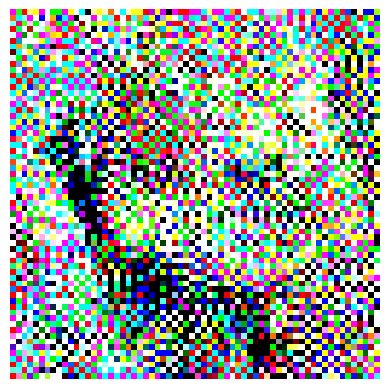

Epoch 96: 100%|███████████████| 405/405 [05:38<00:00,  1.20 steps/s, loss=0.122]


2024-04-13 03:00:19.297091 Epoch 96, Training loss 0.12895714148438622


Epoch 97: 100%|███████████████| 405/405 [05:38<00:00,  1.20 steps/s, loss=0.117]


2024-04-13 03:05:57.986335 Epoch 97, Training loss 0.12929054547853658


Epoch 98: 100%|███████████████| 405/405 [05:38<00:00,  1.20 steps/s, loss=0.128]


2024-04-13 03:11:37.392633 Epoch 98, Training loss 0.1284509349632733


Epoch 99: 100%|███████████████| 405/405 [05:38<00:00,  1.20 steps/s, loss=0.147]


2024-04-13 03:17:16.723815 Epoch 99, Training loss 0.1276440516738175


Epoch 100: 100%|███████████████| 405/405 [05:38<00:00,  1.20 steps/s, loss=0.13]


2024-04-13 03:22:56.004426 Epoch 100, Training loss 0.12854993427768716


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

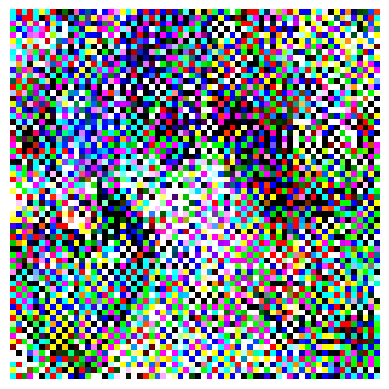

Epoch 101: 100%|██████████████| 405/405 [05:38<00:00,  1.20 steps/s, loss=0.124]


2024-04-13 03:28:44.391563 Epoch 101, Training loss 0.12747716652275307


Epoch 102: 100%|██████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.115]


2024-04-13 03:34:24.443905 Epoch 102, Training loss 0.1269368371316071


Epoch 103: 100%|██████████████| 405/405 [05:40<00:00,  1.19 steps/s, loss=0.119]


2024-04-13 03:40:05.101328 Epoch 103, Training loss 0.1270996255460631


Epoch 104: 100%|██████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.131]


2024-04-13 03:45:44.958189 Epoch 104, Training loss 0.12621354638355706


Epoch 105: 100%|██████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.125]


2024-04-13 03:51:24.478257 Epoch 105, Training loss 0.12647697997504267


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

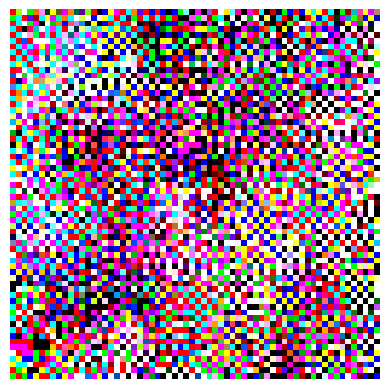

Epoch 106: 100%|██████████████| 405/405 [05:39<00:00,  1.19 steps/s, loss=0.123]


2024-04-13 03:57:13.509810 Epoch 106, Training loss 0.12563620749952759


Epoch 107:  20%|███▏            | 80/405 [01:07<04:33,  1.19 steps/s, loss=0.14]

In [ ]:
print("Total parameters: ",count_parameters(model))
loss_fn = nn.MSELoss()  #  <4>
#loss_fn = nn.L1Loss()

training_loop(  # <5>
    n_epochs = 1000,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    device = device,
    batch_size = 64,
    epoch_start = 1,
    timesteps = timesteps
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


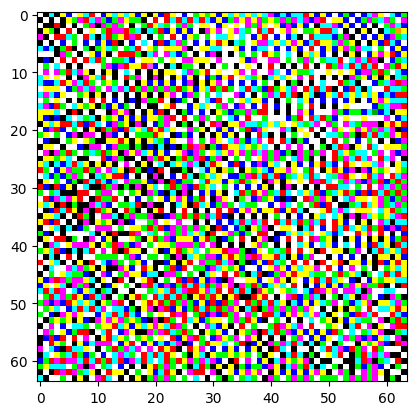

In [13]:
inference(model, device)

In [ ]:
x_0 = torch.rand(10,3,128,128).numpy()
t = torch.range(1,10)
print(t.shape)
sg, ns = forward_noise(0,x_0,t)
print(sg.shape)
print(ns.shape)